## Lecture 5 - Convolutional neural networks

> A deep dive into convolutional neural networks for jet tagging

## Learning objectives

* Know how to implement and train a convolutional neural network in PyTorch
* Learn how to debug unstable training runs with activation statistics
* Understand what the 1-cycle training policy is
* Understand what batch normalization is and how to incorporate it into a CNN

## References

* Chapter 13 of [_Deep Learning for Coders with fastai & PyTorch_](https://github.com/fastai/fastbook) by Jeremy Howard and Sylvain Gugger.
* Chapter 11 of [_Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow_](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646/ref=sr_1_1?crid=29Z1GSCOWEPDV&keywords=hands+on+machine+learning+with+scikit-learn+and+tensorflow+2&qid=1653288575&sprefix=hands+on+ma%2Caps%2C160&sr=8-1) by Aurélien Geron

## Setup

In [ ]:
# Uncomment and run this cell if using Colab, Kaggle etc
# %pip install fastai==2.6.0 datasets

## Imports

In [1]:
from datasets import load_dataset
from fastai.callback.hook import *
from fastai.vision.all import *
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset
from torchvision.transforms import ToTensor

In [2]:
import datasets

# Suppress logs to keep things tidy
datasets.logging.set_verbosity_error()

## Loading the data

Last lecture we fine-tuned a pretrained CNN on the top tagging dataset, where each jet was represented as a 2D image of "energy pixels". Today, we'll take a look at training our own CNN from scratch, and explore some of the techniques that fastai utilizes to stabilise the training of these neural nets. To get started, let's download the same dataset of jet images from last lecture:

  0%|          | 0/3 [00:00<?, ?it/s]

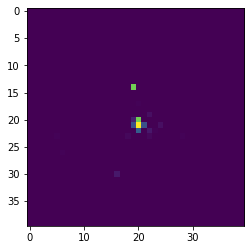

In [3]:
images_ds = load_dataset("dl4phys/top_tagging_images")

# Peek at one example
plt.imshow(images_ds["train"][0]["image"]);

As we saw last lecture, we need to convert these PIL images into PyTorch tensors, so let's reuse the same helper function to create a training and validation set to experiment with:

In [4]:
def get_dataset(dataset, num_examples=None):
    if num_examples is not None:
        dataset = dataset.shuffle(seed=42).select(range(num_examples))

    x = torch.cat([ToTensor()(img) for img in dataset["image"]]).unsqueeze(1)
    y = torch.cat([torch.tensor(l).unsqueeze(0) for l in dataset["label"]])

    return TensorDataset(x, y)

With this function, we can now generate a sample of jets as follows:

In [5]:
# Lower the training size if Colab RAM explodes 💣
train_ds = get_dataset(images_ds["train"], num_examples=350_000)
valid_ds = get_dataset(images_ds["validation"], num_examples=35_000)

Since we'll be experimenting a bit with the batch size in this lecture, we'll also implement a helper function to return the dataloaders associated with these datasets:

In [6]:
def get_dls(bs=128):
    train_dl = DataLoader(train_ds, bs=bs, shuffle=True)
    valid_dl = DataLoader(valid_ds, bs=bs)
    return DataLoaders(train_dl, valid_dl)

Now that we have this function, we can get the dataloaders and grab a batch of data to test with:

In [7]:
dls = get_dls()

xb, yb = first(dls.train)
xb.shape, yb.shape

(torch.Size([128, 1, 40, 40]), torch.Size([128]))

## Creating a CNN

Recall in lecture 3, that we created a neural network for $N$-subjettiness features. We used the `nn.Sequential()` class to create a network that involved stacking fully-connected layers and ReLU activation functions:

In [8]:
model = nn.Sequential(
    nn.Linear(20, 200),
    nn.ReLU(),
    nn.Linear(200, 2),
)

model

Sequential(
  (0): Linear(in_features=20, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=2, bias=True)
)

In this lecture, we'll take a similar approach, but this time using _convolutional layers_ instead of linear ones. In PyTorch, convolutional layers are created by using the `nn.Conv2d()` module. Let's try replacing the `nn.Linear()` layers in our previous architecture with `nn.Conv2d()` ones instead:

In [9]:
broken_cnn = nn.Sequential(
    nn.Conv2d(1, 30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30, 1, kernel_size=3, padding=1),
)

Note that unlike linear layers, convolutional layers don't require us to specify the number of features in the input. That's because convolutions are applied across each pixel automatically, so the weights only depend on the number of channels and the kernel size. 

Let's now see what happens if we pass a minibatch of data through this model:

In [10]:
# Feed a minibatch to the model
outputs = broken_cnn(xb)
outputs.shape

torch.Size([128, 1, 40, 40])

Hmm, this output isn't quite what we want for classification: we need a tensor of shape `(batch_size, num_classes)` but instead have a $40\times 40$ map of activations. The standard way to handle this is to apply a sequence of _stride-2 convolutions_, which decrease the size of the outputs so that the final layer size is 1. To see why this is the case, recall that for an image of height $n_H$ and width $n_W$, the dimension of the output activation map is given by:

$$\left( \left\lfloor\frac{n_H + 2p - k}{s} + 1 \right\rfloor ,  \left\lfloor\frac{n_W + 2p - k}{s} + 1 \right\rfloor \right) \,,$$

where $p$ is the padding, $k$ the kernel of size $k\times k$, and $s$ the stride. For fixed $p,f$ and $s>1$, we can see that the dimension of the activation map is shrunk with each convolutional layer.

With this in mind, let's create a stack of stride-2 convolutional layers with $3\times 3$ kernels. We'll intersperse each convolutional layer with a ReLU activation, so let's write a helper function that returns the two together:

In [11]:
def conv(ni, nf, ks=3, act=True):
    layer = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks // 2)
    if act:
        layer = nn.Sequential(layer, nn.ReLU())
    return layer

As discussed in the fastai book, it's good practice to increase the number of output features `nf` with each convolutional layer. That's because, stride-2 convolutions decrease the size of the activation map, so we increase the number of output features to avoid compressing the capacity of our model. We also set the kernel size `ks` to the typical value of $3\times 3$, and set the padding to $ks//2$ to ensure the output activation map is the same shape as the input image.

We can now build a CNN by stacking the `conv()` function until we reach a $1\times 1$ activation map:

In [12]:
simple_cnn = nn.Sequential(
    conv(1, 4),  # 20x20
    conv(4, 8),  # 10x10
    conv(8, 16),  # 5x5
    conv(16, 32),  # 3x3
    conv(32, 16),  # 2x2
    conv(16, 2, act=False),  # 1x1
    Flatten(),
)

learn = Learner(
    dls, simple_cnn, metrics=[accuracy, RocAucBinary()], loss_func=F.cross_entropy
)
learn.summary()

Sequential (Input shape: 128 x 1 x 40 x 40)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 4 x 20 x 20   
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 8 x 10 x 10   
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     128 x 16 x 5 x 5    
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     128 x 32 x 3 x 3    
Conv2d                                    4640       True      
ReLU                                         

Since the final convolutional layer will be a tensor of shape $128\times2\times1\times1$, we've stripped off those final $1\times 1$ axes via the `Flatten()` module. We can now verify that the output of this model is in a form suitable for classification:

In [13]:
simple_cnn(xb).shape

torch.Size([128, 2])

Okay, this looks good, so let's find a good learning rate and train for a few epochs:

SuggestedLRs(valley=0.03981071710586548)

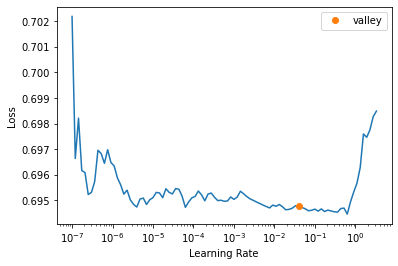

In [14]:
learn.lr_find()

In [15]:
learn.fit(3, 3e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.251922,0.257991,0.892286,0.957853,00:12
1,0.248150,0.243493,0.899114,0.963003,00:12
2,0.231296,0.237253,0.900543,0.964258,00:12


This model is much worse than the pretrained ResNet34 model that we fine-tuned in the previous lecture. We can also see that we've started overfitting quite strongly after the first epoch (because the training and validation losses are diverging). Let's now see if we can make the model more accurate and train it even faster by using some of the techniques that the factory learners (like `vision_learner()`) provide under the hood.

## Debugging training with activation statistics

One way to train a more accurate CNN is simply double the number of filters in each stride-2 layer. However, increasing the number of filters also requires us to increase the kernel size. For example, if our first layer increases the number of filters from 4 to 8, then a $3 \times 3$ kernel will not force the CNN to learn any useful features. To handle that, we'll increase the kernel size to $5\times 5$ and adjust the CNN architecture as follows:

In [16]:
def simple_cnn():
    return nn.Sequential(
        conv(1, 8, ks=5),  # 20x20
        conv(8, 16),  # 10x10
        conv(16, 32),  # 5x5
        conv(32, 64),  # 3x3
        conv(64, 128),  # 2x2
        conv(128, 2, act=False),  # 1x1
        Flatten(),
    ).to("cuda")

Since we'll be training this network in several ways, let's wrap the creation of the `Learner` and training in a `fit()` function:

In [17]:
def fit(epochs=1, lr=0.06):
    learn = Learner(
        dls,
        simple_cnn(),
        metrics=[accuracy, RocAucBinary()],
        loss_func=F.cross_entropy,
        cbs=ActivationStats(with_hist=True),
    )
    learn.fit(epochs, lr)
    return learn

To give a sense for what can go wrong when training CNNs, we've used a much larger learning rate than before. We've also use the `ActivationStats()` callback, which records the statistics of the activations in each layer - this will be handy for debugging. Let's see how well this model performs after 1 epoch:

In [18]:
learn = fit()

/home/lewis/miniconda3/envs/dl4phys/lib/python3.9/site-packages/fastai/callback/core.py:67: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.694601,0.693960,0.500343,0.500000,00:19


Okay, it seems the large learning rate has given us a model than doesn't perform better than random chance. To diagnose the problem, we can use the `plot_layer_stats()` method that the `ActivationStats` callback has tracked. For example, here are the mean and standard deviation of the activations in the first layer:

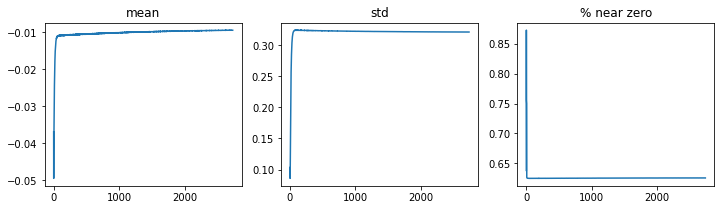

In [19]:
learn.activation_stats.plot_layer_stats(0)

Here we can see that the mean and standard deviation have a somewhat dramatic spike / drop in the early stages of training. A bigger problem is that the fraction of activations that are near zero is almost 1 after a few iterations. This is a problem because activations that are zero in one layer, will propagate zeros to the next layer, and so on. As a result, these parts of the network are effectively turned off, which makes the learning process suboptimal. 

Let's now have a look at the last convolutional layer in the CNN:

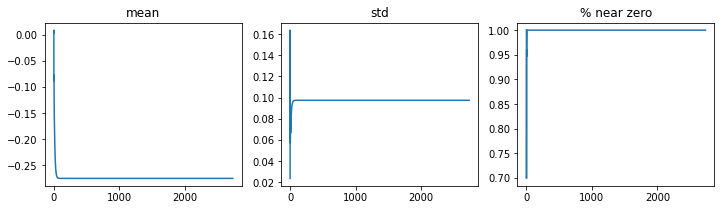

In [20]:
learn.activation_stats.plot_layer_stats(-2)

Here we see a similar pattern, with the fraction of near zero activations reaching almost 1 in fewer iterations. Let's see if we can imprve the situation by increasing the batch size.

### Increasing the batch size

If you're GPU can handle it, increasing the batch size is one technique that can sometimes stabilise training. This is because a larger batch size implies more accurate gradients, so SGD can potentially train more efficiently. Let's try increasing our batch size by a factor of 4, training the model and investigating the activation statistics:

/home/lewis/miniconda3/envs/dl4phys/lib/python3.9/site-packages/fastai/callback/core.py:67: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.693562,0.693991,0.499657,0.500000,00:12


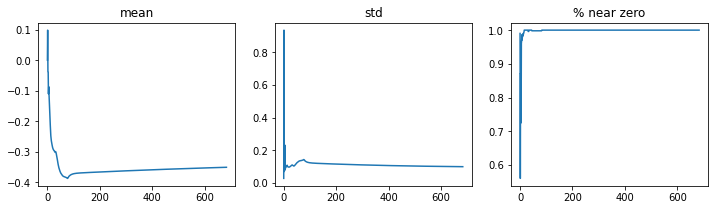

In [21]:
dls = get_dls(512)
learn = fit()
learn.activation_stats.plot_layer_stats(-2)

Okay, increasing the batch size hasn't helped much. Clearly the problem is that our learning rate is too large, which is causing training to diverge. One way to handle this is to use a _dynamic_ learning rate that is adjusted from low to high, and back to low values during training itself! Let's take a look at 1-cycle training and finally understand what's going one when we call `Learner.fit_one_cycle()`.

### 1-cycle training

The basic idea behind 1-cycle training is to split training into two phases:

* **Warmup:** grow the learning rate from some minimum to maximum value. By starting with a small learning rate, we can avoid hopping out of a local minimum in the loss and diverging.
* **Annealing:** decrease the learning rate from the maximum value to the minimum. By gradually lowering the learning rate, we avoid skipping a good local minimum towards the end of training.

This technique is one of the main aspects that allows fastai to train fast and accurate models. As we've done in previous lectures, we can use the `fit_one_cycle()` method, so let's adjust our `fit()` function and train again:

In [22]:
def fit(epochs=1, lr=0.06):
    learn = Learner(
        dls,
        simple_cnn(),
        metrics=[accuracy, RocAucBinary()],
        loss_func=F.cross_entropy,
        cbs=ActivationStats(with_hist=True),
    )
    learn.fit_one_cycle(epochs, lr)
    return learn

learn = fit()

/home/lewis/miniconda3/envs/dl4phys/lib/python3.9/site-packages/fastai/callback/core.py:67: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.255070,0.257523,0.892029,0.957344,00:12


Nice, we've finally got a model that performs better than random! All fastai `Learner`s come with a `Recorder()` callback, which tracks various aspect of training. Here we can use it to inspect the evolution of the learning rate:

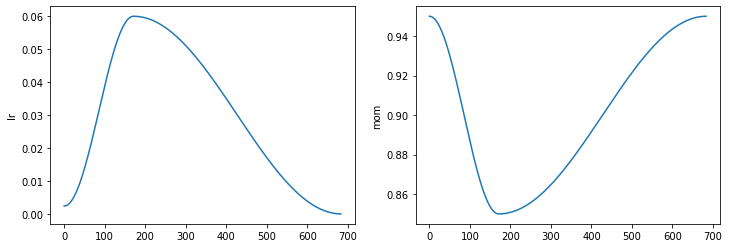

In [23]:
learn.recorder.plot_sched()

Here we can see the learning rate increases linearly until the maximum value, before being annealed with a cosine function. The second plot refers to a hyperparameter called _momentum_, which takes values between $[0,1]$ and is often denoted by $\beta$. This hyperparameter belongs to a technique called _momentum optimization_, which extends SGD to speed up training. Recall that in SGD, we update our weights and biases according to the following update rule:

$$ \theta \to \theta' = \theta - \eta \nabla_\theta L(\theta) .$$

One problem with this rule, is that if the gradients are small in some region, then the subsequent updates will also be small and training can be slow. To deal with this, momentum optimization uses an _exponentially weighted average_ to modify the update rule:

\begin{align}
\mathbf{m}'&= \beta\mathbf{m} + (1-\beta)\nabla_\theta L(\theta) \\
\theta' &= \theta - \eta\mathbf{m}'
\end{align}

Intuitively, the momentum vector $\mathbf{m}$ is storing a running average of past gradient values, and this enables the update step to pick directions based on these averages. The result is that SGD with momentum allows us to traverse the loss landscape much faster (especially through plateaus). 

Let's now have a look at the activation statistics in the final `conv()` layer:

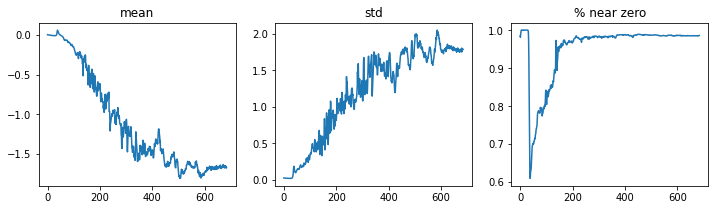

In [25]:
learn.activation_stats.plot_layer_stats(-2)

Okay, we've getting somewhat better, but we still have quite a few activations getting close to zero towards the end of training. Let's look at one last technique that can help us deal with this.

### Batch normalization

A very effective technique to deal with vanishing activations in training is to use _batch normalization_ (or batchnorm for short). This techniuqe tries to maintain a good distribution of activations during training by applying a normalization operation just before or after each hidden layer. The way this works is to zero-center and normalize the activations in each layer by introducing two new parameters $\gamma$ and $\beta$ (not the same $\beta$ from momentum!). The parameters are used to learn the optimal scale of the inputs across each layer, and the batchnorm operation can be summarised in the following equations:

\begin{align}
\mathbf{\mu}_B &= \frac{1}{m_B} \sum_i \mathbf{x}^{(i)} \\
\sigma_B^2 &= \frac{1}{m_B} \sum_i \left(\mathbf{x}^{(i)} - \mathbf{\mu}_B\right)^2  \\
\hat{\mathbf{x}}^{(i)}  &= \frac{\mathbf{x}^{(i)} - \mathbf{\mu}_B}{\sqrt{\mathbf{\sigma}_B^2 + \epsilon}} \\
\mathbf{z}^{(i)} &= \mathbf{\gamma} \odot \hat{\mathbf{x}}^{(i)} + \mathbf{\beta}
\end{align}

These statistics make it easier to train models, since we don't have to enforce a global normalization on the data (as we did with the `MinMaxScaler()` in previous lectures).

Implementing batchnorm in PyTorch is rather simple: we just add a `nn.BatchNorm2d()` layer after each convolution:

In [26]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks // 2)]
    layers.append(nn.BatchNorm2d(nf))
    if act:
        layers.append(nn.ReLU())
    return nn.Sequential(*layers)

Let's now train the model again with 1-cycle policy training:

In [27]:
learn = fit()

/home/lewis/miniconda3/envs/dl4phys/lib/python3.9/site-packages/fastai/callback/core.py:67: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.216597,0.214471,0.909714,0.970490,00:22


Nice! This is pretty great result after just one epoch of training, and gets is quite close to the results quoted for CNNs in the top taggin review paper. Let's also inspect the activation statistics:

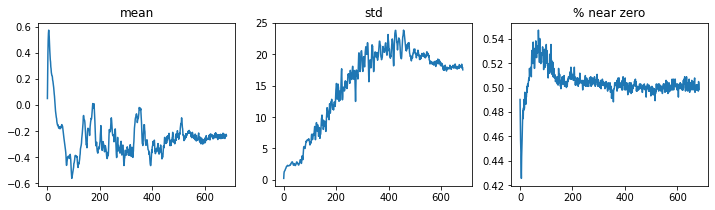

In [28]:
learn.activation_stats.plot_layer_stats(-2)

This is looking much better: the activations evolve smoothly and we've managed to prevent half of the activations from vanishing. Since batchnorm claims to work with large learning rates, let's ramp this up to 0.1 and see what we get:

In [87]:
learn = fit(10, lr=0.1)

/home/lewis/miniconda3/envs/dl4phys/lib/python3.9/site-packages/fastai/callback/core.py:67: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.241621,0.324524,0.879571,0.951736,00:22
1,0.232091,1.657844,0.655914,0.913255,00:21
2,0.222661,0.819799,0.612086,0.906052,00:21
3,0.220339,0.276002,0.885429,0.957145,00:21
4,0.217905,0.410375,0.813257,0.920187,00:21
5,0.209055,0.433610,0.802971,0.920204,00:21
6,0.204782,0.363477,0.832943,0.945951,00:21
7,0.198509,0.206748,0.913429,0.972911,00:21
8,0.191656,0.202564,0.916000,0.974434,00:21
9,0.182151,0.196292,0.918886,0.975237,00:21


Great, this has given us a small boost and only took a few minutes to train a CNN form scratch!

## Exercises

* Implement the same CNN architecture from the review. Can you get close to their results?
* Read the [1-cycle policy training paper](https://arxiv.org/abs/1708.07120)